In [2]:
import numpy as np
from scipy.integrate import solve_ivp


class RosslerMap:
    """
    Rossler attractor
    With a=0.2, b=0.2, and c=5.7
    """

    def __init__(_, a=0.2, b=0.2, c=5.7, delta_t=1e-3):
        _.a, _.b, _.c = a, b, c
        _.delta_t = delta_t

    def v_eq(_, t=None, v=None):
        x, y, z = v[0], v[1], v[2]
        dot_x = -y - z
        dot_y = x + _.a*y
        dot_z = _.b + z*(x-_.c)
        return np.array([dot_x, dot_y, dot_z])

    def jacobian(_, v):
        x, z = v[0], v[2]
        res = np.array([[       0,      -1,       -1],
                       [        1,     _.a,        0],
                       [        z,       0,   x-_.c]])
        return res

    def full_traj(_, nb_steps, init_pos):
        t = np.linspace(0, nb_steps * _.delta_t, nb_steps)
        f = solve_ivp(_.v_eq, [0, nb_steps * _.delta_t], init_pos, method='RK45', t_eval=t)
        return np.moveaxis(f.y, -1, 0),t
    
    def equilibrium(_):
        x0 = (_.c-np.sqrt(_.c**2-4*_.a*_.b))/2
        y0 = (-_.c+np.sqrt(_.c**2-4*_.a*_.b))/(2*_.a)
        z0 = (_.c-np.sqrt(_.c**2-4*_.a*_.b))/(2*_.a)
        return np.array([x0,y0,z0])

equilibrium state : [ 0.0070262  -0.03513102  0.03513102] , error :  2.0811522028509542e-13


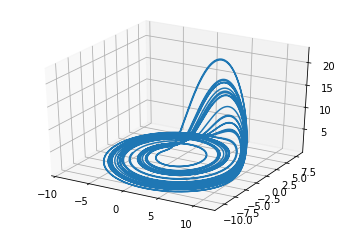

In [5]:
import numpy as np
from numpy.linalg import qr, solve, norm
from scipy.linalg import expm
#from rossler_map import RosslerMap

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def lyapunov_exponent(traj, jacobian, max_it=1000, delta_t=1e-3):

    n = traj.shape[1]
    w = np.eye(n)
    rs = []
    chk = 0

    for i in range(max_it):
        jacob = jacobian(traj[i,:]).reshape(n,n)

        #WARNING this is true for the jacobian of the continuous system!
        w_next = np.dot(expm(jacob * delta_t),w) 
        #if delta_t is small you can use:
        #w_next = np.dot(np.eye(n)+jacob * delta_t,w)
    
        w_next, r_next = qr(w_next)

        # qr computation from numpy allows negative values in the diagonal
        # Next three lines to have only positive values in the diagonal
        d = np.diag(np.sign(r_next.diagonal()))
        w_next = np.dot(w_next, d)
        r_next = np.dot(d, r_next.diagonal())

        rs.append(r_next)
        w = w_next
        if i//(max_it/100)>chk:
            print(i//(max_it/100))
            chk +=1
    
    return  np.mean(np.log(rs), axis=0) / delta_t

def newton(f,jacob,x, gen=True):
    #newton raphson method
    tol =1
    while tol>1e-5:
        #WARNING this is true for the jacobian of the continuous system!
        tol = x
        if gen: x = x-solve(jacob(x),f(x, True))
        else: x = x-solve(jacob(x),f(v=x))
        tol = norm(tol-x)
    return x
    
     
    
if __name__ == '__main__':

    Niter = 20000
    delta_t = 1e-2
    ROSSLER_MAP = RosslerMap(delta_t=delta_t)
    INIT = np.array([-5.75, -1.6,  0.02])
    traj,t = ROSSLER_MAP.full_traj(Niter, INIT)
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(traj[:,0], traj[:,1], traj[:,2])
    
    fix_point = newton(ROSSLER_MAP.v_eq,ROSSLER_MAP.jacobian,INIT, False)

    error = norm(fix_point-ROSSLER_MAP.equilibrium())
    print("equilibrium state :", fix_point, ", error : ", error)
    
    #lyap = lyapunov_exponent(traj, ROSSLER_MAP.jacobian, max_it=Niter, delta_t=delta_t)
    #print("Lyapunov Exponents :", lyap, "with delta t =", delta_t)

    plt.show()

In [30]:
import torch
import torch.nn as nn
import numpy as np

class GRUNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=500, output_dim=1, 
                       n_layers=2, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU( input_dim, hidden_dim, n_layers, 
                           batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

#from rossler_map import RosslerMap


class RDataset(Dataset):
    def __init__(self, size, init, delta_t, history, scale=False):
        super().__init__()
        self.size = size
        self.init = init
        self.delta_t = delta_t
        self.history = history
        self.mask = torch.ones((self.history + 2, 1))
        self.mask[-1, 0] = 0  # Set target to 0

        self.rm = RosslerMap(delta_t=delta_t)

        self.w, self.t = self.rm.full_traj(size, init)
        if scale:
          scaler =MinMaxScaler(feature_range=(-1, 1))
          self.w = scaler.fit_transform(self.w)

        self.w = torch.tensor(self.w).float()

    def __len__(self):
        return self.size - 1 - self.history

    def __getitem__(self, idx):
        return self.w[idx : idx + self.history + 2]
        

# Loss functions
def loss_v0(preds, gt, criterion=nn.MSELoss()):
    return criterion(preds, gt)

def loss_v1(preds, gt, criterion=nn.MSELoss()):

    d_preds = (preds[1:] - preds[:-1]) / args.dt
    d_gt = (gt[1:] - gt[:-1]) / args.dt

    loss = criterion(preds, gt) + args.lamda*criterion(d_preds, d_gt)
    return loss

def loss_v2(preds, gt,  criterion=nn.MSELoss()):

    d_preds = (preds[1:] - preds[:-1]) / args.dt

    loss = criterion(preds, gt) + args.lamda*torch.sqrt(torch.sum(d_preds**2))
    return loss

In [74]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split

#import argparse
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

#from models import My_Model, GRUNet
#from rossler_map import RosslerMap
#from utils import RDataset, loss_v0, loss_v1, loss_v2

#-------------------------------------------------------------------------------
#                              Second Approach Training
#-------------------------------------------------------------------------------
def train_rnn(model=None, criterion=None, optimizer=None, scheduler=None, epochs=10, dataset_size=1000,
          batch_size=10, log_interval=20, exp_name='test', device=None, history=0):

    delta_t = 1e-2
    ROSSLER_MAP = RosslerMap(delta_t=delta_t)

    model.to(device)
    model.train()

    init = np.array([-5.75, -1.6, 0.02])
    dataset = RDataset(dataset_size, init, delta_t, history, scale=False)

    train_size = int(len(dataset) * 0.8)
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=4,
                              pin_memory=False,
                              drop_last=True)

    for epoch in tqdm(range(epochs)):
        h = model.init_hidden(batch_size)
        for (i,batch) in enumerate(train_loader):
            
            in_traj = batch[:,:history,1].to(device)
            in_traj = in_traj.view((batch.shape[0], history, -1))
            gt = batch[:,-1,1].to(device)  # labels are just the same batch but shifted

            h = h.data

            model.zero_grad()
            # optimizer.zero_grad()
            #print(i,in_traj.shape, h.shape)
            out, h = model(in_traj.to(device), h.to(device))
            loss = criterion(out.view(-1), gt.to(device))

            loss.backward(retain_graph=False)
            optimizer.step()
        scheduler.step()
        
        if epoch % log_interval == 0:
            print('Loss : ', loss.item())
            model_file = "models/" + exp_name + '_model_'+ str(epoch) +'.pth'
            print('saving :', model_file)
            torch.save(model.state_dict(), model_file)


In [75]:
epochs = 1000
lr = 0.0001
exp_name = 'basic_lossv0'
batch_size = 30
dataset_size = 100000 #5000000
log_interval = 1
dt = 1e-2
history = 32
lamda = 1
rnn = False

# If we have a GPU available, we'll set our device to GPU. 
is_cuda = torch.cuda.is_available()
    
if is_cuda: print("on GPU") 
else: print("on CPU")
    
device = torch.device("cuda") if is_cuda else torch.device("cpu")
    
model_rnn = GRUNet( input_dim=1, hidden_dim=500, output_dim=1, n_layers=2)
optimizer = torch.optim.Adam(params=model_rnn.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

on GPU


In [76]:
train_rnn( model=model_rnn, criterion=loss_v0, epochs=epochs,
                   optimizer=optimizer, scheduler=scheduler, exp_name=exp_name, batch_size=batch_size,
                   dataset_size=dataset_size, log_interval=log_interval, 
                   device=device, history=history)










  0%|          | 0/1000 [00:00<?, ?it/s]








  0%|          | 1/1000 [00:24<6:52:28, 24.77s/it]

Loss :  0.00425727991387248
saving : models/basic_lossv0_model_0.pth











  0%|          | 2/1000 [00:49<6:53:22, 24.85s/it]

Loss :  0.0017192099476233125
saving : models/basic_lossv0_model_1.pth











  0%|          | 3/1000 [01:14<6:51:24, 24.76s/it]

Loss :  0.0020537255331873894
saving : models/basic_lossv0_model_2.pth











  0%|          | 4/1000 [01:39<6:50:37, 24.74s/it]

Loss :  0.001789366127923131
saving : models/basic_lossv0_model_3.pth











  0%|          | 5/1000 [02:03<6:47:50, 24.59s/it]

Loss :  0.0009610946290194988
saving : models/basic_lossv0_model_4.pth











  1%|          | 6/1000 [02:27<6:44:22, 24.41s/it]

Loss :  0.0010269418125972152
saving : models/basic_lossv0_model_5.pth











  1%|          | 7/1000 [02:51<6:43:51, 24.40s/it]

Loss :  0.0009097848669625819
saving : models/basic_lossv0_model_6.pth











  1%|          | 8/1000 [03:15<6:41:45, 24.30s/it]

Loss :  0.0013936545001342893
saving : models/basic_lossv0_model_7.pth











  1%|          | 9/1000 [03:39<6:40:26, 24.25s/it]

Loss :  0.0008229561499319971
saving : models/basic_lossv0_model_8.pth











  1%|          | 10/1000 [04:03<6:39:04, 24.19s/it]

Loss :  0.0006332346238195896
saving : models/basic_lossv0_model_9.pth











  1%|          | 11/1000 [04:28<6:39:51, 24.26s/it]

Loss :  0.0013531454605981708
saving : models/basic_lossv0_model_10.pth











  1%|          | 12/1000 [04:53<6:42:02, 24.42s/it]

Loss :  0.0011235856218263507
saving : models/basic_lossv0_model_11.pth











  1%|▏         | 13/1000 [05:17<6:41:55, 24.43s/it]

Loss :  0.0008430714951828122
saving : models/basic_lossv0_model_12.pth











  1%|▏         | 14/1000 [05:42<6:41:39, 24.44s/it]

Loss :  0.0013226686278358102
saving : models/basic_lossv0_model_13.pth











  2%|▏         | 15/1000 [06:06<6:41:09, 24.44s/it]

Loss :  0.000981840887106955
saving : models/basic_lossv0_model_14.pth











  2%|▏         | 16/1000 [06:31<6:42:14, 24.53s/it]

Loss :  0.0009087779326364398
saving : models/basic_lossv0_model_15.pth











  2%|▏         | 17/1000 [06:55<6:42:09, 24.55s/it]

Loss :  0.0011122205760329962
saving : models/basic_lossv0_model_16.pth











  2%|▏         | 18/1000 [07:20<6:42:59, 24.62s/it]

Loss :  0.000617142824921757
saving : models/basic_lossv0_model_17.pth











  2%|▏         | 19/1000 [07:45<6:42:05, 24.59s/it]

Loss :  0.0010594003833830357
saving : models/basic_lossv0_model_18.pth











  2%|▏         | 20/1000 [08:09<6:41:03, 24.55s/it]

Loss :  0.0011928294552490115
saving : models/basic_lossv0_model_19.pth











  2%|▏         | 21/1000 [08:34<6:40:35, 24.55s/it]

Loss :  0.0007276287069544196
saving : models/basic_lossv0_model_20.pth











  2%|▏         | 22/1000 [08:58<6:40:37, 24.58s/it]

Loss :  0.0006303880945779383
saving : models/basic_lossv0_model_21.pth











  2%|▏         | 23/1000 [09:23<6:40:08, 24.57s/it]

Loss :  0.0006666214321739972
saving : models/basic_lossv0_model_22.pth











  2%|▏         | 24/1000 [09:47<6:38:29, 24.50s/it]

Loss :  0.0010444585932418704
saving : models/basic_lossv0_model_23.pth











  2%|▎         | 25/1000 [10:12<6:37:29, 24.46s/it]

Loss :  0.001285096863284707
saving : models/basic_lossv0_model_24.pth











  3%|▎         | 26/1000 [10:36<6:38:02, 24.52s/it]

Loss :  0.0008909731404855847
saving : models/basic_lossv0_model_25.pth











  3%|▎         | 27/1000 [11:00<6:36:27, 24.45s/it]

Loss :  0.0007601157994940877
saving : models/basic_lossv0_model_26.pth











  3%|▎         | 28/1000 [11:25<6:35:41, 24.43s/it]

Loss :  0.00044129230082035065
saving : models/basic_lossv0_model_27.pth











  3%|▎         | 29/1000 [11:49<6:34:14, 24.36s/it]

Loss :  0.0009537349687889218
saving : models/basic_lossv0_model_28.pth











  3%|▎         | 30/1000 [12:14<6:34:57, 24.43s/it]

Loss :  0.0008307400275953114
saving : models/basic_lossv0_model_29.pth











  3%|▎         | 31/1000 [12:38<6:35:04, 24.46s/it]

Loss :  0.0007943922537378967
saving : models/basic_lossv0_model_30.pth











  3%|▎         | 32/1000 [13:02<6:33:33, 24.39s/it]

Loss :  0.0007961791707202792
saving : models/basic_lossv0_model_31.pth











  3%|▎         | 33/1000 [13:27<6:32:08, 24.33s/it]

Loss :  0.0007948818965815008
saving : models/basic_lossv0_model_32.pth











  3%|▎         | 34/1000 [13:51<6:31:55, 24.34s/it]

Loss :  0.0010238083777949214
saving : models/basic_lossv0_model_33.pth











  4%|▎         | 35/1000 [14:16<6:34:28, 24.53s/it]

Loss :  0.0008360526408068836
saving : models/basic_lossv0_model_34.pth











  4%|▎         | 36/1000 [14:41<6:34:52, 24.58s/it]

Loss :  0.0008889048476703465
saving : models/basic_lossv0_model_35.pth











  4%|▎         | 37/1000 [15:05<6:35:10, 24.62s/it]

Loss :  0.0007541957311332226
saving : models/basic_lossv0_model_36.pth











  4%|▍         | 38/1000 [15:30<6:35:03, 24.64s/it]

Loss :  0.0009221881628036499
saving : models/basic_lossv0_model_37.pth











  4%|▍         | 39/1000 [15:55<6:35:50, 24.71s/it]

Loss :  0.00048578137648291886
saving : models/basic_lossv0_model_38.pth











  4%|▍         | 40/1000 [16:20<6:35:46, 24.74s/it]

Loss :  0.0009943483164533973
saving : models/basic_lossv0_model_39.pth











  4%|▍         | 41/1000 [16:44<6:35:31, 24.75s/it]

Loss :  0.0008315885788761079
saving : models/basic_lossv0_model_40.pth











  4%|▍         | 42/1000 [17:09<6:34:23, 24.70s/it]

Loss :  0.0012602165807038546
saving : models/basic_lossv0_model_41.pth











  4%|▍         | 43/1000 [17:33<6:32:26, 24.60s/it]

Loss :  0.000774472369812429
saving : models/basic_lossv0_model_42.pth











  4%|▍         | 44/1000 [17:58<6:31:17, 24.56s/it]

Loss :  0.0008997155237011611
saving : models/basic_lossv0_model_43.pth











  4%|▍         | 45/1000 [18:23<6:31:14, 24.58s/it]

Loss :  0.0009378478862345219
saving : models/basic_lossv0_model_44.pth











  5%|▍         | 46/1000 [18:47<6:30:29, 24.56s/it]

Loss :  0.0006326950388029218
saving : models/basic_lossv0_model_45.pth











  5%|▍         | 47/1000 [19:11<6:28:04, 24.43s/it]

Loss :  0.0008331452263519168
saving : models/basic_lossv0_model_46.pth











  5%|▍         | 48/1000 [19:36<6:27:56, 24.45s/it]

Loss :  0.0008471294422633946
saving : models/basic_lossv0_model_47.pth











  5%|▍         | 49/1000 [20:00<6:27:57, 24.48s/it]

Loss :  0.0004447116225492209
saving : models/basic_lossv0_model_48.pth











  5%|▌         | 50/1000 [20:25<6:28:22, 24.53s/it]

Loss :  0.0010383807821199298
saving : models/basic_lossv0_model_49.pth











  5%|▌         | 51/1000 [20:49<6:27:49, 24.52s/it]

Loss :  0.0009775202488526702
saving : models/basic_lossv0_model_50.pth











  5%|▌         | 52/1000 [21:14<6:26:24, 24.46s/it]

Loss :  0.0007527616107836366
saving : models/basic_lossv0_model_51.pth











  5%|▌         | 53/1000 [21:38<6:26:43, 24.50s/it]

Loss :  0.0008228247752413154
saving : models/basic_lossv0_model_52.pth











  5%|▌         | 54/1000 [22:03<6:27:39, 24.59s/it]

Loss :  0.0007620539981871843
saving : models/basic_lossv0_model_53.pth











  6%|▌         | 55/1000 [22:28<6:28:19, 24.66s/it]

Loss :  0.0013472938444465399
saving : models/basic_lossv0_model_54.pth











  6%|▌         | 56/1000 [22:52<6:27:18, 24.62s/it]

Loss :  0.0006876669940538704
saving : models/basic_lossv0_model_55.pth











  6%|▌         | 57/1000 [23:17<6:28:54, 24.74s/it]

Loss :  0.000819354085251689
saving : models/basic_lossv0_model_56.pth











  6%|▌         | 58/1000 [23:42<6:29:36, 24.82s/it]

Loss :  0.0008623531903140247
saving : models/basic_lossv0_model_57.pth











  6%|▌         | 59/1000 [24:07<6:28:12, 24.75s/it]

Loss :  0.000794402789324522
saving : models/basic_lossv0_model_58.pth











  6%|▌         | 60/1000 [24:32<6:27:45, 24.75s/it]

Loss :  0.0010431475238874555
saving : models/basic_lossv0_model_59.pth











  6%|▌         | 61/1000 [24:56<6:25:43, 24.65s/it]

Loss :  0.001203658408485353
saving : models/basic_lossv0_model_60.pth











  6%|▌         | 62/1000 [25:21<6:24:07, 24.57s/it]

Loss :  0.0008155075483955443
saving : models/basic_lossv0_model_61.pth











  6%|▋         | 63/1000 [25:45<6:24:37, 24.63s/it]

Loss :  0.0010847519151866436
saving : models/basic_lossv0_model_62.pth











  6%|▋         | 64/1000 [26:10<6:22:40, 24.53s/it]

Loss :  0.001470278948545456
saving : models/basic_lossv0_model_63.pth











  6%|▋         | 65/1000 [26:34<6:21:55, 24.51s/it]

Loss :  0.0005477319937199354
saving : models/basic_lossv0_model_64.pth











  7%|▋         | 66/1000 [26:58<6:20:54, 24.47s/it]

Loss :  0.0008992128423415124
saving : models/basic_lossv0_model_65.pth











  7%|▋         | 67/1000 [27:23<6:19:31, 24.41s/it]

Loss :  0.0009103618212975562
saving : models/basic_lossv0_model_66.pth











  7%|▋         | 68/1000 [27:47<6:19:16, 24.42s/it]

Loss :  0.0014399909414350986
saving : models/basic_lossv0_model_67.pth











  7%|▋         | 69/1000 [28:12<6:19:28, 24.46s/it]

Loss :  0.001547516672872007
saving : models/basic_lossv0_model_68.pth











  7%|▋         | 70/1000 [28:36<6:19:46, 24.50s/it]

Loss :  0.0007852697744965553
saving : models/basic_lossv0_model_69.pth











  7%|▋         | 71/1000 [29:01<6:21:13, 24.62s/it]

Loss :  0.0008441607351414859
saving : models/basic_lossv0_model_70.pth











  7%|▋         | 72/1000 [29:26<6:21:19, 24.65s/it]

Loss :  0.0009280082304030657
saving : models/basic_lossv0_model_71.pth











  7%|▋         | 73/1000 [29:51<6:21:31, 24.69s/it]

Loss :  0.000896317942533642
saving : models/basic_lossv0_model_72.pth











  7%|▋         | 74/1000 [30:15<6:19:50, 24.61s/it]

Loss :  0.000778654997702688
saving : models/basic_lossv0_model_73.pth











  8%|▊         | 75/1000 [30:40<6:19:14, 24.60s/it]

Loss :  0.0006978806923143566
saving : models/basic_lossv0_model_74.pth











  8%|▊         | 76/1000 [31:04<6:17:17, 24.50s/it]

Loss :  0.0010723350569605827
saving : models/basic_lossv0_model_75.pth











  8%|▊         | 77/1000 [31:29<6:17:07, 24.52s/it]

Loss :  0.0008641177555546165
saving : models/basic_lossv0_model_76.pth











  8%|▊         | 78/1000 [31:53<6:17:54, 24.59s/it]

Loss :  0.0010961714433506131
saving : models/basic_lossv0_model_77.pth











  8%|▊         | 79/1000 [32:18<6:18:22, 24.65s/it]

Loss :  0.0008908159215934575
saving : models/basic_lossv0_model_78.pth











  8%|▊         | 80/1000 [32:43<6:17:52, 24.64s/it]

Loss :  0.0006909466465003788
saving : models/basic_lossv0_model_79.pth











  8%|▊         | 81/1000 [33:07<6:16:28, 24.58s/it]

Loss :  0.00120028096716851
saving : models/basic_lossv0_model_80.pth











  8%|▊         | 82/1000 [33:32<6:17:22, 24.66s/it]

Loss :  0.0007538588833995163
saving : models/basic_lossv0_model_81.pth











  8%|▊         | 83/1000 [33:57<6:16:47, 24.65s/it]

Loss :  0.000858931802213192
saving : models/basic_lossv0_model_82.pth











  8%|▊         | 84/1000 [34:21<6:13:45, 24.48s/it]

Loss :  0.0010041286004707217
saving : models/basic_lossv0_model_83.pth











  8%|▊         | 85/1000 [34:45<6:12:50, 24.45s/it]

Loss :  0.00202997331507504
saving : models/basic_lossv0_model_84.pth











  9%|▊         | 86/1000 [35:10<6:12:17, 24.44s/it]

Loss :  0.0009661298827268183
saving : models/basic_lossv0_model_85.pth











  9%|▊         | 87/1000 [35:34<6:12:58, 24.51s/it]

Loss :  0.0009892425732687116
saving : models/basic_lossv0_model_86.pth











  9%|▉         | 88/1000 [35:59<6:13:18, 24.56s/it]

Loss :  0.000487351615447551
saving : models/basic_lossv0_model_87.pth











  9%|▉         | 89/1000 [36:23<6:12:13, 24.52s/it]

Loss :  0.0006571905687451363
saving : models/basic_lossv0_model_88.pth











  9%|▉         | 90/1000 [36:48<6:11:08, 24.47s/it]

Loss :  0.0007551148883067071
saving : models/basic_lossv0_model_89.pth











  9%|▉         | 91/1000 [37:12<6:10:39, 24.47s/it]

Loss :  0.0008834161562845111
saving : models/basic_lossv0_model_90.pth











  9%|▉         | 92/1000 [37:37<6:10:06, 24.46s/it]

Loss :  0.001219681347720325
saving : models/basic_lossv0_model_91.pth











  9%|▉         | 93/1000 [38:01<6:09:15, 24.43s/it]

Loss :  0.00048530573258176446
saving : models/basic_lossv0_model_92.pth











  9%|▉         | 94/1000 [38:25<6:08:16, 24.39s/it]

Loss :  0.0007007939857430756
saving : models/basic_lossv0_model_93.pth











 10%|▉         | 95/1000 [38:49<6:07:10, 24.34s/it]

Loss :  0.00115499971434474
saving : models/basic_lossv0_model_94.pth











 10%|▉         | 96/1000 [39:14<6:06:07, 24.30s/it]

Loss :  0.0010297688422724605
saving : models/basic_lossv0_model_95.pth











 10%|▉         | 97/1000 [39:38<6:06:41, 24.37s/it]

Loss :  0.0006986109656281769
saving : models/basic_lossv0_model_96.pth











 10%|▉         | 98/1000 [40:02<6:05:39, 24.32s/it]

Loss :  0.0007876972085796297
saving : models/basic_lossv0_model_97.pth











 10%|▉         | 99/1000 [40:27<6:05:27, 24.34s/it]

Loss :  0.0008754203445278108
saving : models/basic_lossv0_model_98.pth











 10%|█         | 100/1000 [40:51<6:05:38, 24.38s/it]

Loss :  0.0014508236199617386
saving : models/basic_lossv0_model_99.pth











 10%|█         | 101/1000 [41:16<6:06:05, 24.43s/it]

Loss :  0.0006435312679968774
saving : models/basic_lossv0_model_100.pth











 10%|█         | 102/1000 [41:40<6:06:46, 24.51s/it]

Loss :  0.0006286220159381628
saving : models/basic_lossv0_model_101.pth











 10%|█         | 103/1000 [42:05<6:08:02, 24.62s/it]

Loss :  0.0010970615549013019
saving : models/basic_lossv0_model_102.pth











 10%|█         | 104/1000 [42:30<6:06:51, 24.57s/it]

Loss :  0.0014344326918944716
saving : models/basic_lossv0_model_103.pth











 10%|█         | 105/1000 [42:55<6:07:25, 24.63s/it]

Loss :  0.0012528618099167943
saving : models/basic_lossv0_model_104.pth











 11%|█         | 106/1000 [43:19<6:08:20, 24.72s/it]

Loss :  0.0006307977018877864
saving : models/basic_lossv0_model_105.pth











 11%|█         | 107/1000 [43:44<6:08:52, 24.78s/it]

Loss :  0.0013104334939271212
saving : models/basic_lossv0_model_106.pth











 11%|█         | 108/1000 [44:09<6:09:00, 24.82s/it]

Loss :  0.00044089442235417664
saving : models/basic_lossv0_model_107.pth











 11%|█         | 109/1000 [44:34<6:09:16, 24.87s/it]

Loss :  0.001118102460168302
saving : models/basic_lossv0_model_108.pth











 11%|█         | 110/1000 [44:59<6:07:16, 24.76s/it]

Loss :  0.000529699376784265
saving : models/basic_lossv0_model_109.pth











 11%|█         | 111/1000 [45:23<6:06:04, 24.71s/it]

Loss :  0.0008470549364574254
saving : models/basic_lossv0_model_110.pth











 11%|█         | 112/1000 [45:48<6:05:47, 24.72s/it]

Loss :  0.0008629868971183896
saving : models/basic_lossv0_model_111.pth











 11%|█▏        | 113/1000 [46:13<6:06:35, 24.80s/it]

Loss :  0.000883574946783483
saving : models/basic_lossv0_model_112.pth











 11%|█▏        | 114/1000 [46:38<6:05:57, 24.78s/it]

Loss :  0.000976292765699327
saving : models/basic_lossv0_model_113.pth











 12%|█▏        | 115/1000 [47:03<6:07:01, 24.88s/it]

Loss :  0.0013823246117681265
saving : models/basic_lossv0_model_114.pth











 12%|█▏        | 116/1000 [47:28<6:05:37, 24.82s/it]

Loss :  0.000784499105066061
saving : models/basic_lossv0_model_115.pth











 12%|█▏        | 117/1000 [47:52<6:03:13, 24.68s/it]

Loss :  0.0008117904071696103
saving : models/basic_lossv0_model_116.pth











 12%|█▏        | 118/1000 [48:17<6:01:55, 24.62s/it]

Loss :  0.0002823979302775115
saving : models/basic_lossv0_model_117.pth











 12%|█▏        | 119/1000 [48:41<6:01:54, 24.65s/it]

Loss :  0.000615329947322607
saving : models/basic_lossv0_model_118.pth











 12%|█▏        | 120/1000 [49:06<6:02:45, 24.73s/it]

Loss :  0.0005117647815495729
saving : models/basic_lossv0_model_119.pth











 12%|█▏        | 121/1000 [49:31<6:02:44, 24.76s/it]

Loss :  0.000542669789865613
saving : models/basic_lossv0_model_120.pth











 12%|█▏        | 122/1000 [49:55<6:01:00, 24.67s/it]

Loss :  0.0006399800186045468
saving : models/basic_lossv0_model_121.pth











 12%|█▏        | 123/1000 [50:20<6:00:51, 24.69s/it]

Loss :  0.0010334545513615012
saving : models/basic_lossv0_model_122.pth











 12%|█▏        | 124/1000 [50:45<6:00:36, 24.70s/it]

Loss :  0.0007514188182540238
saving : models/basic_lossv0_model_123.pth











 12%|█▎        | 125/1000 [51:10<6:00:54, 24.75s/it]

Loss :  0.0015475383261218667
saving : models/basic_lossv0_model_124.pth











 13%|█▎        | 126/1000 [51:34<5:59:39, 24.69s/it]

Loss :  0.0012092575198039412
saving : models/basic_lossv0_model_125.pth











 13%|█▎        | 127/1000 [51:59<5:58:33, 24.64s/it]

Loss :  0.0012255414621904492
saving : models/basic_lossv0_model_126.pth











 13%|█▎        | 128/1000 [52:23<5:58:07, 24.64s/it]

Loss :  0.0006415859097614884
saving : models/basic_lossv0_model_127.pth











 13%|█▎        | 129/1000 [52:48<5:58:57, 24.73s/it]

Loss :  0.0010137722129002213
saving : models/basic_lossv0_model_128.pth











 13%|█▎        | 130/1000 [53:13<5:56:58, 24.62s/it]

Loss :  0.0010253078071400523
saving : models/basic_lossv0_model_129.pth











 13%|█▎        | 131/1000 [53:37<5:55:38, 24.56s/it]

Loss :  0.000668294494971633
saving : models/basic_lossv0_model_130.pth











 13%|█▎        | 132/1000 [54:02<5:55:25, 24.57s/it]

Loss :  0.0016783173196017742
saving : models/basic_lossv0_model_131.pth











 13%|█▎        | 133/1000 [54:26<5:54:24, 24.53s/it]

Loss :  0.000699565454851836
saving : models/basic_lossv0_model_132.pth











 13%|█▎        | 134/1000 [54:51<5:54:18, 24.55s/it]

Loss :  0.0009653405868448317
saving : models/basic_lossv0_model_133.pth











 14%|█▎        | 135/1000 [55:15<5:53:36, 24.53s/it]

Loss :  0.0006943133193999529
saving : models/basic_lossv0_model_134.pth











 14%|█▎        | 136/1000 [55:40<5:52:50, 24.50s/it]

Loss :  0.0005433431942947209
saving : models/basic_lossv0_model_135.pth











 14%|█▎        | 137/1000 [56:04<5:53:15, 24.56s/it]

Loss :  0.0009371263440698385
saving : models/basic_lossv0_model_136.pth











 14%|█▍        | 138/1000 [56:29<5:52:30, 24.54s/it]

Loss :  0.0005599085707217455
saving : models/basic_lossv0_model_137.pth











 14%|█▍        | 139/1000 [56:53<5:51:11, 24.47s/it]

Loss :  0.0008580301073379815
saving : models/basic_lossv0_model_138.pth











 14%|█▍        | 140/1000 [57:18<5:50:19, 24.44s/it]

Loss :  0.0007624949212186038
saving : models/basic_lossv0_model_139.pth











 14%|█▍        | 141/1000 [57:42<5:50:03, 24.45s/it]

Loss :  0.0007696564425714314
saving : models/basic_lossv0_model_140.pth











 14%|█▍        | 142/1000 [58:06<5:49:22, 24.43s/it]

Loss :  0.0010530994040891528
saving : models/basic_lossv0_model_141.pth











 14%|█▍        | 143/1000 [58:31<5:48:07, 24.37s/it]

Loss :  0.0011125144083052874
saving : models/basic_lossv0_model_142.pth











 14%|█▍        | 144/1000 [58:55<5:46:46, 24.31s/it]

Loss :  0.000641977705527097
saving : models/basic_lossv0_model_143.pth











 14%|█▍        | 145/1000 [59:19<5:45:01, 24.21s/it]

Loss :  0.000688207452185452
saving : models/basic_lossv0_model_144.pth











 15%|█▍        | 146/1000 [59:43<5:43:53, 24.16s/it]

Loss :  0.0006244218675419688
saving : models/basic_lossv0_model_145.pth











 15%|█▍        | 147/1000 [1:00:07<5:43:33, 24.17s/it]

Loss :  0.0009689480648376048
saving : models/basic_lossv0_model_146.pth











 15%|█▍        | 148/1000 [1:00:31<5:43:43, 24.21s/it]

Loss :  0.0010375193087384105
saving : models/basic_lossv0_model_147.pth











 15%|█▍        | 149/1000 [1:00:56<5:43:11, 24.20s/it]

Loss :  0.0009383133728988469
saving : models/basic_lossv0_model_148.pth











 15%|█▌        | 150/1000 [1:01:20<5:43:01, 24.21s/it]

Loss :  0.0007722218870185316
saving : models/basic_lossv0_model_149.pth











 15%|█▌        | 151/1000 [1:01:44<5:43:49, 24.30s/it]

Loss :  0.0013161110691726208
saving : models/basic_lossv0_model_150.pth











 15%|█▌        | 152/1000 [1:02:09<5:43:53, 24.33s/it]

Loss :  0.0004790001839864999
saving : models/basic_lossv0_model_151.pth











 15%|█▌        | 153/1000 [1:02:33<5:42:16, 24.25s/it]

Loss :  0.0010271903593093157
saving : models/basic_lossv0_model_152.pth











 15%|█▌        | 154/1000 [1:02:57<5:41:35, 24.23s/it]

Loss :  0.00040587500552646816
saving : models/basic_lossv0_model_153.pth











 16%|█▌        | 155/1000 [1:03:21<5:41:24, 24.24s/it]

Loss :  0.0009043387835845351
saving : models/basic_lossv0_model_154.pth











 16%|█▌        | 156/1000 [1:03:45<5:40:16, 24.19s/it]

Loss :  0.0010055352468043566
saving : models/basic_lossv0_model_155.pth











 16%|█▌        | 157/1000 [1:04:09<5:38:37, 24.10s/it]

Loss :  0.0005318921757861972
saving : models/basic_lossv0_model_156.pth











 16%|█▌        | 158/1000 [1:04:33<5:36:31, 23.98s/it]

Loss :  0.0013757171109318733
saving : models/basic_lossv0_model_157.pth











 16%|█▌        | 159/1000 [1:04:57<5:37:00, 24.04s/it]

Loss :  0.000681815727148205
saving : models/basic_lossv0_model_158.pth











 16%|█▌        | 160/1000 [1:05:21<5:37:08, 24.08s/it]

Loss :  0.001329431077465415
saving : models/basic_lossv0_model_159.pth











 16%|█▌        | 161/1000 [1:05:46<5:37:41, 24.15s/it]

Loss :  0.0008424764382652938
saving : models/basic_lossv0_model_160.pth











 16%|█▌        | 162/1000 [1:06:10<5:37:24, 24.16s/it]

Loss :  0.000735615729354322
saving : models/basic_lossv0_model_161.pth











 16%|█▋        | 163/1000 [1:06:34<5:37:04, 24.16s/it]

Loss :  0.0008996761171147227
saving : models/basic_lossv0_model_162.pth











 16%|█▋        | 164/1000 [1:06:58<5:35:59, 24.11s/it]

Loss :  0.0011123456060886383
saving : models/basic_lossv0_model_163.pth











 16%|█▋        | 165/1000 [1:07:22<5:35:23, 24.10s/it]

Loss :  0.0011042198166251183
saving : models/basic_lossv0_model_164.pth











 17%|█▋        | 166/1000 [1:07:46<5:35:38, 24.15s/it]

Loss :  0.0006881938898004591
saving : models/basic_lossv0_model_165.pth











 17%|█▋        | 167/1000 [1:08:10<5:33:59, 24.06s/it]

Loss :  0.0009157723980024457
saving : models/basic_lossv0_model_166.pth


KeyboardInterrupt: ignored

In [91]:
#import argparse
# from script.interpolate import interp1d
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

#from rossler_map import RosslerMap
#from models import My_Model
#from TP import lyapunov_exponent, newton


import scipy
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
rnn_history = 32
class Rossler_model:
    def __init__(self, delta_t=1e-2, model=None, steps=10000, scale=False, init=[-5.75, -1.6, 0.02]):

        self.delta_t = delta_t #if discrete model your delta_t
                              #if continuous model chose one <=1e-2
        self.nb_steps = int(steps//self.delta_t)

        self.rosler_nn = model
        self.initial_condition = np.array(init)
        self.init = init
        self.scaler = scaler
        self.scale = scale

    def full_traj_rnn(self, ):
        # run your model to generate the time series with nb_steps
        # just the y cordinate is necessary.

        ROSSLER_MAP = RosslerMap(delta_t=self.delta_t)
        traj, t = ROSSLER_MAP.full_traj(rnn_history, self.init)
        if self.scale:
            traj = self.scaler.fit_transform(traj)

        h = self.rosler_nn.init_hidden(1)
        traj_tensor = torch.from_numpy(traj).float()

        w = traj_tensor[:rnn_history, 1]  # (history, 1)
        w = w.view((1, w.shape[0], 1))
        # w = torch.from_numpy(self.initial_condition).float()
        traj = []
        for i in tqdm(range(self.nb_steps)):

            w_new, h = self.rosler_nn(w, h)
            traj.append(w_new[0].item())
            w[:, -1, :] = w_new

        y = np.array(traj)

        # if your delta_t is different to 1e-2 then interpolate y
        # in a discrete time array t_new = np.linspace(0,10000, 10000//1e-2)
        # y_new = interp1d(t_new, your_t, your_y)
        # I expect that y.shape = (1000000,)
        return y

    def full_traj(self,):
        # run your model to generate the time series with nb_steps
        # just the y cordinate is necessary. 

        w = torch.from_numpy(self.initial_condition).float()
        traj = []
        for i in tqdm(range(self.nb_steps)):
            w_new = self.rosler_nn(w)
            traj.append(w_new[1].item())
            w = w_new

        y = np.array(traj)

        #if your delta_t is different to 1e-2 then interpolate y
        #in a discrete time array t_new = np.linspace(0,10000, 10000//1e-2)
        # y_new = interp1d(t_new, your_t, your_y)
        # I expect that y.shape = (1000000,)
        return y

    def save_traj(self,y):
        #save the trajectory in traj.npy file
        # y has to be a numpy array: y.shape = (1000000,)
          
        np.save('traj.npy',y)

def plot_gt_sample(delta_t, init, steps):

    Niter = int(steps // delta_t)
    delta_t = 1e-2
    ROSSLER_MAP = RosslerMap(delta_t=delta_t)
    INIT = np.array(init)
    traj, t = ROSSLER_MAP.full_traj(Niter, INIT)
    y = traj[:, 1]
    fig = plt.figure(10)
    plt.title('Ground truth map')

    plt.plot(y)
    return y
    # plt.show()

def plot_3d(y, i, delta_t, init, steps):
    print(y.shape)
    Niter = int(steps // delta_t)
    ROSSLER_MAP = RosslerMap(delta_t=delta_t)
    INIT = np.array(init)
    traj, t = ROSSLER_MAP.full_traj(Niter, INIT)
    if scale:
        traj = scaler.fit_transform(traj)

    fig1 = plt.figure(i)
    ax = fig1.gca(projection='3d')
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2])

    fig2 = plt.figure(i+1)
    ax = fig2.gca(projection='3d')
    ax.plot(traj[:, 0], y, traj[:, 2])



def compute_stats(x, x_gt, name, dt=1e-2):

    
    plt.figure('Histogram')
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + name)
    # plt.text(23, 45, r'$\mu=15, b=3$')
    plt.hist(x=x, bins='auto', alpha=0.7, rwidth=0.85, label=name)


    plt.title('Histogram')
    # plt.text(23, 45, r'$\mu=15, b=3$')
    plt.hist(x=x_gt, bins='auto', alpha=0.7, rwidth=0.85, label='gt')
    plt.legend()
    
    
    plt.figure("CDF")
    plt.title("CDF")
    norm_cdf = scipy.stats.norm.cdf(x)  # calculate the cdf - also discrete
    plt.plot(x, norm_cdf, label=name)
    plt.legend()

    norm_cdf_gt = scipy.stats.norm.cdf(x_gt)  # calculate the cdf - also discrete
    plt.plot(x_gt, norm_cdf_gt, label='gt')
    plt.legend()

    # scipy.stats.pearsonr(x, y)[0]  # Pearson's r
    # scipy.stats.spearmanr(x, y)[0]   # Spearman's rho
    # scipy.stats.kendalltau(x, y)[0]   # Kendall's tau

    ### Auto correlation
    plt.figure("Auto correlation")
    plt.title("Auto correlation")

    auto = pd.plotting.autocorrelation_plot(x)
    auto.plot(labels=name)
    auto.legend()

    auto = pd.plotting.autocorrelation_plot(x_gt)
    auto.plot(labels='gt')
    auto.legend()

    ### Spectral density
    plt.figure("Spectral density")
    plt.title("Spectral density")

    ps = np.abs(np.fft.fft(x)) ** 2
    freqs = np.fft.fftfreq(x.size, dt)
    idx = np.argsort(freqs)
    plt.plot(freqs[idx], ps[idx], label=name)
    plt.legend()

    ps_gt = np.abs(np.fft.fft(x_gt)) ** 2
    freqs_gt = np.fft.fftfreq(x_gt.size, dt)
    idx_gt = np.argsort(freqs_gt)
    plt.plot(freqs_gt[idx_gt], ps_gt[idx_gt], label='gt')
    plt.legend()



Streaming output truncated to the last 5000 lines.





 53%|█████▎    | 5254/9999 [00:59<00:52, 90.34it/s]









 53%|█████▎    | 5264/9999 [00:59<00:52, 89.94it/s]









 53%|█████▎    | 5273/9999 [00:59<00:52, 89.42it/s]









 53%|█████▎    | 5283/9999 [00:59<00:51, 90.76it/s]









 53%|█████▎    | 5293/9999 [00:59<00:52, 90.15it/s]









 53%|█████▎    | 5303/9999 [01:00<00:52, 89.81it/s]









 53%|█████▎    | 5312/9999 [01:00<00:52, 89.34it/s]









 53%|█████▎    | 5321/9999 [01:00<00:52, 88.74it/s]









 53%|█████▎    | 5330/9999 [01:00<00:52, 88.62it/s]









 53%|█████▎    | 5339/9999 [01:00<00:53, 87.78it/s]









 53%|█████▎    | 5348/9999 [01:00<00:54, 86.10it/s]









 54%|█████▎    | 5357/9999 [01:00<00:53, 86.32it/s]









 54%|█████▎    | 5367/9999 [01:00<00:52, 88.01it/s]









 54%|█████▍    | 5376/9999 [01:00<00:53, 87.07it/s]









 54%|█████▍    | 5385/9999 [01:01<00:53, 86.95it/s]









 54%|█████▍    | 5395/9999 [0

(9999,)


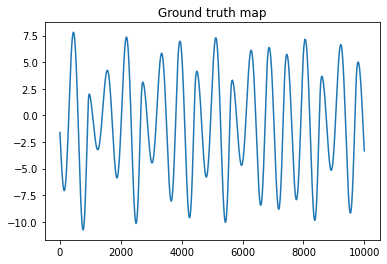

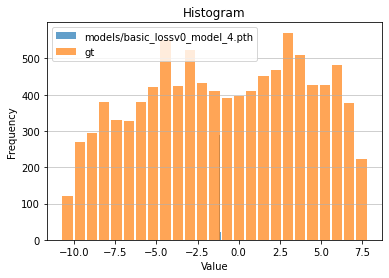

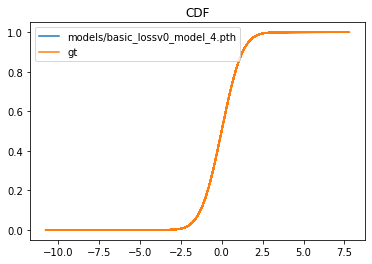

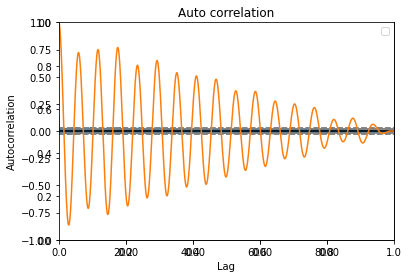

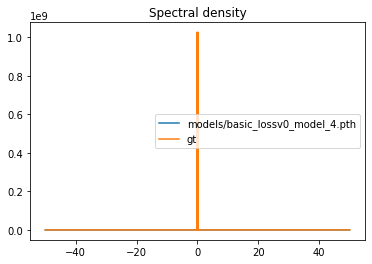

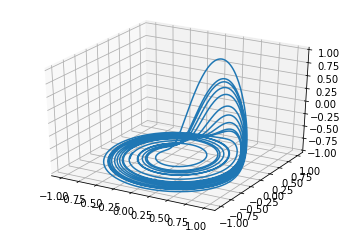

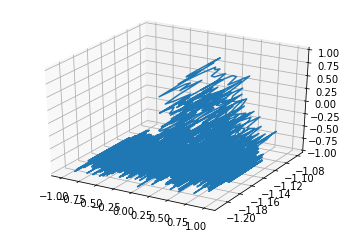

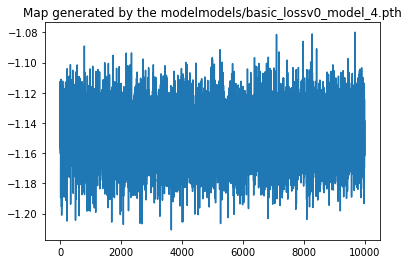

In [92]:
init = [-5.75, -1.6, 0.02]
model_path = 'models/basic_lossv0_model_4.pth'
steps = 100
delta_t = 1e-2
rnn = False
scale = True


is_cuda = torch.cuda.is_available()
device = torch.device("cuda") if is_cuda else torch.device("cpu")

Model = GRUNet( input_dim=1, hidden_dim=500, output_dim=1, n_layers=2)
checkpoint = torch.load(model_path, map_location=device)
Model.load_state_dict(checkpoint)

ROSSLER = Rossler_model( delta_t=delta_t, model=Model, steps=steps, scale=scale)
y = ROSSLER.full_traj_rnn()

# Plotting ground truth
y_gt = plot_gt_sample(delta_t, init, steps)

# Compute some statistics
compute_stats(y, y_gt, name=model_path, dt=delta_t)

# Plotting results 3D
plot_3d(y, 30, delta_t, init, steps)

# save output trajectory
ROSSLER.save_traj(y)

# plotting the generated trajectory
fig = plt.figure("generated trajectory y-coordinate")
plt.title('Map generated by the model' + model_path)
plt.plot(y)

"""    
# we used x and z from the exact model and we focused on our generated y
Niter = int(value.steps//value.delta_t)
ROSSLER_MAP = RosslerMap(delta_t=value.delta_t)
    
ROSSLER_MAP = RosslerMap(delta_t=value.delta_t)
traj, t = ROSSLER_MAP.full_traj(Niter, np.array(value.init))
traj[:,1] = y
##
    
# Compute the Equilibrium Point of the generated map
fix_point = newton(Model, Model.batch_model_jacobian, np.array(value.init))
    
error = norm(fix_point - ROSSLER_MAP.equilibrium())
print("equilibrium state :", fix_point, ", error : ", error)
print()
    
# Compute the Lyapunov Exponent
lyap = lyapunov_exponent(traj, Model.batch_model_jacobian, max_it=Niter, 
                                   delta_t=value.delta_t)
print("Lyapunov Exponents :", lyap, "with delta t =", value.delta_t)
"""
plt.show()